<a href="https://colab.research.google.com/github/yohanesnuwara/66DaysOfData/blob/main/D09_knowledge_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Graph

I would like to try knowledge graph with SpaCy in Python and know some of its limitations.

In [1]:
import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt

Build some functions to take every token (word) of a sentence and put them into category (subject, object, punctuation, adjective, preposition, etc). After that, put every 3 tokens into triples.  

In [2]:
def getSentences(text):
    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]
    
def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''
    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='skyblue', alpha=0.9,
            labels={node: node for node in G.nodes()})
    plt.axis('off')
    plt.show()

In [22]:
def knowledge_graph(text):  
  sentences = getSentences(text)
  nlp_model = spacy.load('en_core_web_sm')
  triples = []

  for sentence in sentences:
      triples.append(processSentence(sentence))

  printGraph(triples)

## Example 1

We have the following sentence. Keywords are "Spain", "5th largest country", "world", "capital city", and "Madrid". This will be arranged into triples:

* "Spain", "5th largest country", "world"
* "Madrid", "capital city", "Spain"

In [44]:
text = 'Spain is the 5th largest country in the world. Madrid is the capital city of Spain.'

Spain -> nsubj
is -> ROOT
the -> det
5th -> amod
largest -> amod
country -> attr
in -> prep
the -> det
world -> pobj
. -> punct
Spain , be 5th large country , world
Madrid -> nsubj
is -> ROOT
the -> det
capital -> compound
city -> attr
of -> prep
Spain -> pobj
. -> punct
Madrid , be city , Spain


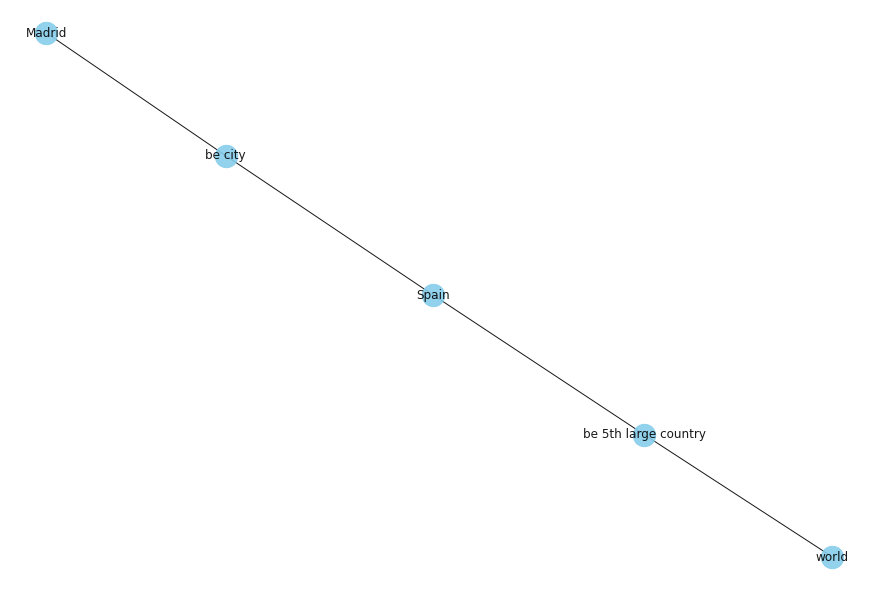

In [45]:
knowledge_graph(text)

The drawback of this knowledge graph is that it only capture "city" instead of "capital city".

## Example 2

In [46]:
text = 'Madrid is the capital city of Spain. The city has almost 3.4 million inhabitants.'

Madrid -> nsubj
is -> ROOT
the -> det
capital -> compound
city -> attr
of -> prep
Spain -> pobj
. -> punct
Madrid , be city , Spain
The -> det
city -> nsubj
has -> ROOT
almost -> advmod
3.4 -> compound
million -> nummod
inhabitants -> dobj
. -> punct
city , have , inhabitants


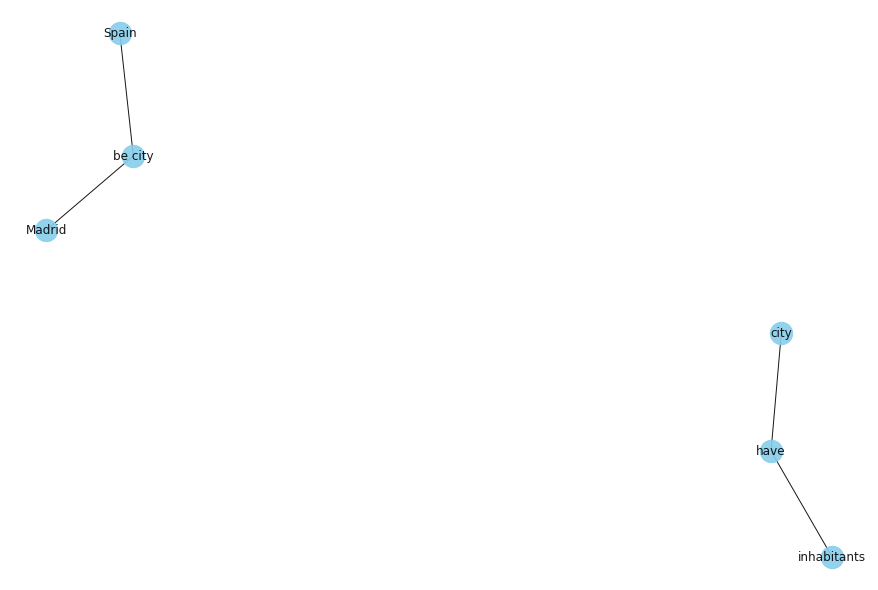

In [49]:
knowledge_graph(text)

The drawback of this knowledge graph is that it cannot capture the word "The city" as reference "Madrid", instead it captures both word as separated entities.

## Example 3

Example of a full paragraph.

In [8]:
# text = "Paris is the capital and most populous city of France, with an estimated population of 2,175,601 residents as of 2018, in an area of more than 105 square kilometres. Since the 17th century, Paris has been one of Europe's major centres of finance, diplomacy, commerce, fashion, gastronomy, science and arts. The City of Paris is the centre and seat of government of the region and province of Île-de-France, or Paris Region, which has an estimated population of 12,174,880, or about 18 percent of the population of France as of 2017. Paris is a major railway, highway and air-transport hub served by two international airports: Paris–Charles de Gaulle (the second busiest airport in Europe) and Paris–Orly. Paris is especially known for its museums and architectural landmarks: the Louvre was the most visited art museum in the world in 2019, with 9.6 million visitors. Paris received 38 million visitors in 2019, measured by hotel stays, with the largest numbers of foreign visitors coming from the United States, the United Kingdom, Germany and China. It was ranked as the second most visited travel destination in the world in 2019, after Bangkok and just ahead of London."

In [20]:
text = 'Madrid is the capital and most-populous city of Spain. The city has almost 3.4 million inhabitants and a metropolitan area population of approximately 6.7 million. It is the second-largest city in the European Union (EU), surpassed only by Berlin in its administrative limits, and its monocentric metropolitan area is the second-largest in the EU, surpassed only by Paris. Madrid lies on the River Manzanares in the center of both the country and the Community of Madrid region, of which it is also the capital. As the capital city of Spain, seat of government, residence of the Spanish monarch, Madrid is also the political, economic and cultural centre of the country. Madrid is home to two world-famous football clubs, Real Madrid and Atlético Madrid. Due to its economic output, high standard of living, and market size, Madrid is considered the major financial centre. Madrid is also the 8th most liveable city in the world according to Monocle magazine, in its 2019 index.'

Madrid -> nsubj
is -> ROOT
the -> det
capital -> attr
and -> cc
most -> advmod
- -> punct
populous -> amod
city -> conj
of -> prep
Spain -> pobj
. -> punct
Madrid , be capital populous , Spain
The -> det
city -> nsubj
has -> ROOT
almost -> advmod
3.4 -> compound
million -> nummod
inhabitants -> dobj
and -> cc
a -> det
metropolitan -> amod
area -> compound
population -> conj
of -> prep
approximately -> advmod
6.7 -> compound
million -> pobj
. -> punct
city , have metropolitan , inhabitants million
It -> nsubj
is -> ROOT
the -> det
second -> advmod
- -> punct
largest -> amod
city -> attr
in -> prep
the -> det
European -> compound
Union -> pobj
( -> punct
EU -> appos
) -> punct
, -> punct
surpassed -> advcl
only -> advmod
by -> prep
Berlin -> pobj
in -> prep
its -> poss
administrative -> amod
limits -> pobj
, -> punct
and -> cc
its -> poss
monocentric -> amod
metropolitan -> amod
area -> nsubj
is -> conj
the -> det
second -> advmod
- -> punct
largest -> attr
in -> prep
the -> det
EU -> po

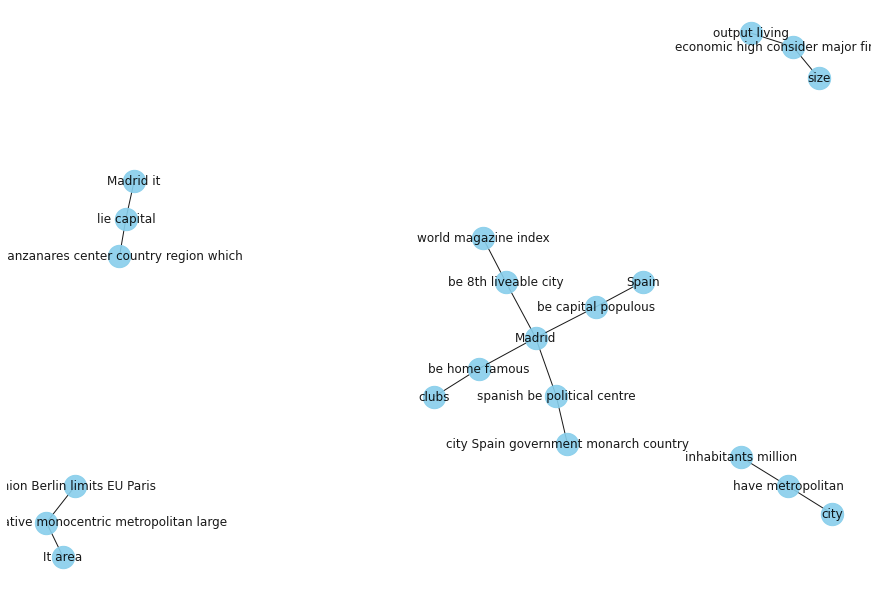

In [25]:
knowledge_graph(text)

References:

* https://analyticsindiamag.com/complete-guide-to-implement-knowledge-graph-using-python/
* https://programmerbackpack.com/python-nlp-tutorial-information-extraction-and-knowledge-graphs/
* https://programmerbackpack.com/python-knowledge-graph-understanding-semantic-relationships/
* https://www.kaggle.com/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk